In [ ]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Installing libraries
! pip install transformers datasets --quiet

In [ ]:
# Importing libraries
import keras
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
# Reading the training set
df_train = pd.read_csv("/content/drive/MyDrive/FND_Kannada/data/v2/train.csv")
df_train = df_train.dropna()
df_train.head()

,news,source,label
0,ಈ ವ್ಯಕ್ತಿ ಪ್ರೌಢಶಾಲೆಯಲ್ಲಿ 26 ಬಾರಿ ಫೇಲ್ ಆಗಿದ್ದಾನೆ,oneindia,0
1,ಸರ್ಕಾರದ ಜೊತೆ ಉದ್ಧವ್ ಠಾಕ್ರೆಯ ಪಕ್ಷವನ್ನೂ ವಶಪಡಿಸ್ಕ...,asianet,1
2,ಹುಲಿ ಸಂರಕ್ಷಿತ ಪ್ರದೇಶ ಘೋಷಣೆ ಸಿಎಂ ನಿರ್ಧಾರಕ್ಕೆ ಉಮ...,prajavani,1
3,108 ಗಂಟೆಯಲ್ಲಿ 75 ಕಿಮೀ ರಸ್ತೆ ನಿರ್ಮಾಣದ ಗುರಿ ಗಿನ್...,asianet,1
4,ಬಾಳಾಠಾಕ್ರೆ ತಿಲಕ ಇಡುತ್ತಿರುವುದು ಏಕನಾಥ್ ಶಿಂಧೆಗಲ್...,asianet,0


In [ ]:
# Reading the testing set
df_test = pd.read_csv("/content/drive/MyDrive/FND_Kannada/data/v2/test.csv")
df_test = df_test.dropna()
df_test.head()

,news,source,label
0,ನಿರಂತರ ಮಳೆ: ಕೊಳೆತ ಉದ್ದು ಬೆಳೆ ...,prajavani,1
1,ಸಲಿಂಗ ಸಂಬಂಧ ವಿರೋಧಿಸಿದ್ದಕ್ಕೆ ಲಿಂಗ ಬದಲಿಸಿಕೊಂಡಳು,asianet,1
2,ನ್ಯೂಯಾರ್ಕ್ ಟೈಮ್ಸ್‌ ಮುಖಪುಟದಲ್ಲಿ ಮೋದಿ ಬಗ್ಗೆ ವರದ...,oneindia,0
3,ಡ್ರೋಣ್ ಬಾಯ್ ಪ್ರತಾಪ್‌ನನ್ನು ವಿಜ್ಞಾನಿಯಾಗಿ DRDOಗೆ ...,factly,0
4,"ಎಸ್ಎಂಕೆ, ನಾರಾಯಣ ಮೂರ್ತಿ, ಪ್ರಕಾಶ್ ಪಡುಕೋಣೆಗೆ ಕೆಂಪ...",asianet,1


In [ ]:
# Create a validation set from the training set
num_of_rows = int(len(df_train) * 0.9)
values = df_train.values
np.random.shuffle(values)
df_train = values[:num_of_rows] #indexes rows for training data
df_validation = values[num_of_rows:] #indexes rows for test data
df_train = pd.DataFrame(df_train,columns=['text','source','label'])
df_validation = pd.DataFrame(df_validation,columns=['text','source','label'])

(2069, 2) (230, 2) (500, 2)


In [ ]:
# Dropping 'source' column
df_train = df_train.drop('source',axis=1)
df_test = df_test.drop('source',axis=1)
df_validation = df_validation.drop('source',axis=1)

In [ ]:
# Rename news column to text to maintain uniformity
df_test.rename(columns={'news':'text'},inplace=True)
print(df_train.shape,df_validation.shape,df_test.shape)

In [ ]:
# Transform train ,validation, test set to Tensorflow dataset
df_train_hg = Dataset(pa.Table.from_pandas(df_train))
df_validation_hg = Dataset(pa.Table.from_pandas(df_validation))
df_test_hg = Dataset(pa.Table.from_pandas(df_test))

In [ ]:
# Define the tokenizer checkpoint
checkpoint = "l3cube-pune/kannada-bert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
# Function to tokenize 'text' column
def tokenize_function(example):
    return tokenizer(example["text"] ,truncation=True)

In [ ]:
# Apply tokenize function to previously created Pyarrow datasets
df_train_tokenised = df_train_hg.map(tokenize_function, batched=True)
df_validation_tokenised = df_validation_hg.map(tokenize_function,batched=True)
df_test_tokenised = df_test_hg.map(tokenize_function, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# Define data collator with its respective parameters
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
# Use data collator to split data into batches for efficient computation
tf_train_dataset = df_train_tokenised.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = df_validation_tokenised.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

tf_test_dataset = df_test_tokenised.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
# Defining the pretrained model to import from huggingface
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint,from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define the hyperparameters

batch_size = 8
num_epochs = 10
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
opt = Adam(learning_rate=lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Compiling the model with the metrics set as 'accuracy'
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [ ]:
# Apply early stopping to prevent overfitting
early_stopping_callback = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 2, patience = 5 )

In [ ]:
# Fit the model as well as store history for plotting training and validation curve
history = model.fit(tf_train_dataset,callbacks=early_stopping_callback, validation_data=tf_validation_dataset,epochs=10,verbose=2)

Epoch 1/10
259/259 - 70s - loss: 0.4416 - accuracy: 0.8154 - val_loss: 0.2645 - val_accuracy: 0.9174 - 70s/epoch - 272ms/step
Epoch 2/10
259/259 - 39s - loss: 0.3051 - accuracy: 0.9000 - val_loss: 0.2294 - val_accuracy: 0.9261 - 39s/epoch - 151ms/step
Epoch 3/10
259/259 - 39s - loss: 0.2235 - accuracy: 0.9275 - val_loss: 0.2415 - val_accuracy: 0.9348 - 39s/epoch - 150ms/step
Epoch 4/10
259/259 - 39s - loss: 0.1380 - accuracy: 0.9628 - val_loss: 0.2425 - val_accuracy: 0.9304 - 39s/epoch - 150ms/step
Epoch 5/10
259/259 - 39s - loss: 0.1163 - accuracy: 0.9676 - val_loss: 0.1626 - val_accuracy: 0.9565 - 39s/epoch - 149ms/step
Epoch 6/10
259/259 - 39s - loss: 0.0646 - accuracy: 0.9816 - val_loss: 0.1814 - val_accuracy: 0.9522 - 39s/epoch - 149ms/step
Epoch 7/10
259/259 - 39s - loss: 0.0311 - accuracy: 0.9947 - val_loss: 0.2567 - val_accuracy: 0.9348 - 39s/epoch - 149ms/step
Epoch 8/10
259/259 - 39s - loss: 0.0232 - accuracy: 0.9966 - val_loss: 0.3090 - val_accuracy: 0.9348 - 39s/epoch - 149

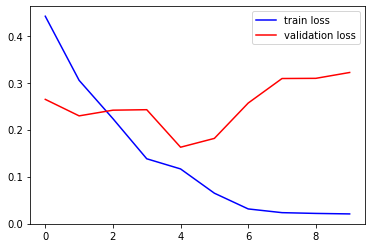

In [ ]:
# Plot loss graph
plt.plot(history.history['loss'], c = 'b', label = 'train loss')
plt.plot(history.history['val_loss'], c = 'r', label = 'validation loss')
plt.legend()
plt.show()

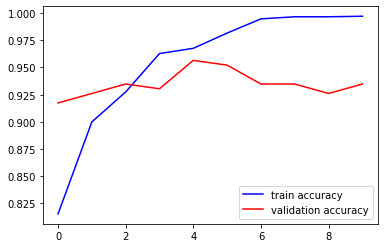

In [ ]:
# Plot accuracty graph
plt.plot(history.history['accuracy'], c = 'b', label = 'train accuracy')
plt.plot(history.history['val_accuracy'] , c = 'r', label = 'validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Retrieve performance metrics
preds = model.predict(tf_test_dataset)["logits"]
class_preds = np.argmax(preds, axis=1)
print(preds.shape, class_preds.shape)

63/63 [==============================] - 5s 38ms/step
(500, 2) (500,)


In [ ]:
# evaluate predictions
y_test = df_test.label.values
y_pred = class_preds
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.80%


In [ ]:
# Generate classification report
print(metrics.classification_report( y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       200
           1       0.91      0.96      0.93       300

    accuracy                           0.92       500
   macro avg       0.92      0.91      0.91       500
weighted avg       0.92      0.92      0.92       500



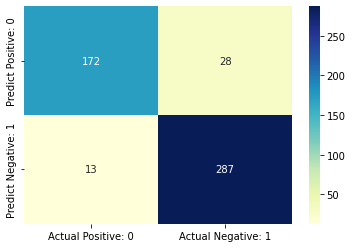

In [ ]:
# Plot confusion matrix
cm_matrix = pd.DataFrame(data = cm, columns = ['Actual Positive: 0', 'Actual Negative: 1'], index = ['Predict Positive: 0', 'Predict Negative: 1'])
sns.heatmap(cm_matrix, annot = True, fmt = 'd', cmap = 'YlGnBu')